## Siamese network 
Steps:
1. load word embeding and document embedding
2. create pytorch dataset and dataloader
3. Try Contrastive loss and triplet loss
4. further improve negative sampling (e.g. hard negative or word2vec negative sampling)

In [1]:
import numpy as np 
import re
import torch
import torch.nn as nn
from itertools import cycle
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
# load word embedding
word2embedding = dict()
embedding_file = "../data/glove.6B.200d.txt"
word_dim = int(re.findall(r".(\d+)d",embedding_file)[0])
with open(embedding_file,"r") as f:
    for line in f:
        line = line.strip().split()
        word = line[0]
        embedding = list(map(float,line[1:]))
        word2embedding[word] = embedding

print("Number of words:%d" % len(word2embedding))

Number of words:400000


In [3]:
class Vocabulary:
    def __init__(self, freq_threshold, word2embedding):
        # The low frequency words will be assigned as <UNK> token
        self.itos = {0: "<UNK>"}
        self.stoi = {"<UNK>": 0}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
        return text.strip().split()

    def build_vocabulary(self, sentence_list):
        self.frequencies = {}
        self.word_vectors = [[0]*word_dim] # init zero padding
        idx = 1
        
        for sentence in tqdm(sentence_list, desc="Preprocessing documents"):
            for word in self.tokenizer_eng(sentence):
                if word not in word2embedding:
                    continue
                if word not in self.frequencies:
                    self.frequencies[word] = 1

                else:
                    self.frequencies[word] += 1

                if self.frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    self.word_vectors.append(word2embedding[word])
                    idx += 1
        self.word_vectors = np.array(self.word_vectors)

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [4]:
class CBowDataset(Dataset):
    def __init__(self, 
                 data_file_path,
                 word2embedding,
                 freq_threshold=20,
                 skip_header = False,
                 max_length = None,
                 neg_nums = 5,
                 ):
        # read data
        self.document_vectors = []
        docEmb_file = open("../data/docvector.txt","r")
        with open(data_file_path,'r',encoding='utf-8') as f:
            if skip_header:
                f.readline()
            self.documents = []
            for line in tqdm(f, desc="Loading documents"):
                if max_length is not None and len(self.documents) >= max_length:
                    break
                self.documents.append(line.strip("\n"))
                doc_vec = docEmb_file.readline().strip().split()
                doc_vec = list(map(float, doc_vec))
                self.document_vectors.append(doc_vec)
        
        # build vocabulary
        self.vocab = Vocabulary(freq_threshold,word2embedding)
        self.vocab.build_vocabulary(self.documents)
        self.vocab_size = len(self.vocab)
        self.neg_nums = neg_nums
        self.words_tokenized = [self.vocab.numericalize(text) for text in self.documents]
        
        # train-test split
        # training
        self.train_length = int(len(self.words_tokenized)*0.8)
        self.train_vectors = self.document_vectors[:self.train_length]
        self.train_words = self.words_tokenized[:self.train_length]
        self.document_ids = list(range(self.train_length))
        self.generator = cycle(self.context_target_generator())
        self.dataset_size = sum([len(s) for s in self.train_words])
        
        # testing
        self.test_vectors = self.document_vectors[self.train_length:]
        self.test_words = self.words_tokenized[self.train_length:]



    def context_target_generator(self):
        np.random.shuffle(self.document_ids) # inplace shuffle

        # randomly select a document and create its training example
        for document_id in self.document_ids: 
            word_list = set(self.train_words[document_id])
            negative_sample_space = list(set(range(self.vocab_size)) - word_list)
            negative_samples = np.random.choice(
                             negative_sample_space,
                             size=len(word_list)*self.neg_nums,
                            replace = False).reshape(len(word_list),self.neg_nums)
            for word_id, negative_wordID in zip(word_list, negative_samples):
                yield [document_id, word_id, negative_wordID]
                
    def __getitem__(self, idx):
        doc_id, word_id, negative_wordID = next(self.generator)
        doc_id = torch.FloatTensor(self.document_vectors[doc_id])
        word_id = torch.FloatTensor(self.vocab.word_vectors[word_id])
        negative_word = torch.FloatTensor(self.vocab.word_vectors[negative_wordID,:])

        return doc_id, word_id, negative_word

    def __len__(self):
        return self.dataset_size 


In [5]:
# load and build torch dataset
data_file_path = '../data/IMDB.txt'
# checkpoint_path = "doc2vecC_lr0.001.pt"
print("Building dataset....")
dataset = CBowDataset(
                    data_file_path=data_file_path,
                    word2embedding=word2embedding,
                    max_length=None,
                    freq_threshold=20,
                    skip_header=False
                    )
print("Finish building dataset!")
print(f"Number of documents:{len(dataset.documents)}")
print(f"Number of words:{dataset.vocab_size}")

Loading documents: 1312it [00:00, 13119.04it/s]

Building dataset....


Loading documents: 100000it [00:08, 12444.08it/s]
Preprocessing documents: 100%|██████████| 100000/100000 [00:11<00:00, 8535.75it/s]


Finish building dataset!
Number of documents:100000
Number of words:27961


In [6]:
class TestDataset(Dataset):
    def __init__(self, 
                 doc_vectors,
                 ans_words,
                 ):
        self.doc_vectors = doc_vectors
        self.ans_words = ans_words
        assert len(doc_vectors) == len(ans_words)
        
    def __getitem__(self, idx):
        doc_vec = torch.FloatTensor(self.doc_vectors[idx])
        ans_w = torch.tensor(list(set(self.ans_words[idx])))
        return doc_vec, ans_w

    def collate_fn(self,batch):
        # Batch: List of tuples [(batch1), (batch2)]
        
        doc_vec = torch.cat([item[0].unsqueeze(0) for item in batch], dim=0)
        ans_w = [item[1] for item in batch]
        ans_w = pad_sequence(ans_w, batch_first=True, padding_value=-1)
        
        return doc_vec, ans_w 

    def __len__(self):
        return len(self.doc_vectors)


In [7]:
class TripletNet(nn.Module):
    def __init__(self, hdim):
        super(TripletNet, self).__init__()
        self.fc = nn.Sequential(nn.Linear(hdim, 512),
                        nn.LeakyReLU(),
                        nn.Linear(512, 512),
                        nn.LeakyReLU(),
                        nn.Linear(512, 2)
                        )

    def forward(self, x1, x2, x3):
        output1 = self.fc(x1)
        output2 = self.fc(x2)
        output3 = self.fc(x3)
        return output1, output2, output3

    def get_embedding(self, x):
        return self.fc(x)

In [8]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        anchor, positive = anchor.unsqueeze(1), positive.unsqueeze(1)
        distance_positive = (anchor - positive).pow(2).sum(-1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(-1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

In [9]:
margin = 5.
BATCH_SIZE = 2048
EPOCH = 300

device = "cuda:0"
model = TripletNet(word_dim).to(device)
loss_fn = TripletLoss(margin).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)

In [10]:
train_loader = DataLoader(
                        dataset, 
                        batch_size=BATCH_SIZE,
                        num_workers=4,
                        shuffle=True,
                        )

In [11]:
test_docvec = dataset.test_vectors
test_ans = dataset.test_words
test_dataset = TestDataset(test_docvec,test_ans)
test_loader = DataLoader(test_dataset,                         
                         batch_size=BATCH_SIZE,
                         num_workers=4,
                         collate_fn=test_dataset.collate_fn)
word_embedding_tensor = torch.FloatTensor(dataset.vocab.word_vectors).to(device)

In [17]:
def evaluate(test_word_emb, loader,Ks = [50,100,150,200]):
    avg_precision, avg_recall = [], []
    for batch in loader:
        batch = [item.to(device) for item in batch]
        emb, ans = batch
        emb = model.get_embedding(emb)
        scores = torch.cdist(emb, test_word_emb)
        ans_length = torch.sum((~ans.eq(-1)).float(), dim=-1)
        mask = ~ans.eq(-1).unsqueeze(-1)
        
        # calculate precision and recall
        tmp_pr, tmp_re = [],[]
        for K in Ks:
            top_indices = torch.argsort(scores,dim=1)[:,:K]
            hit = top_indices.unsqueeze(-2) == ans.unsqueeze(-1)
            hit = torch.sum((hit * mask).flatten(1),dim=-1)
            precision = hit / torch.min(ans_length,torch.tensor(K).to(device))
            recall = hit / ans_length
            tmp_pr.append(precision)
            tmp_re.append(recall)
        tmp_pr = torch.stack(tmp_pr).T.detach().cpu().numpy().tolist()
        tmp_re = torch.stack(tmp_re).T.detach().cpu().numpy().tolist()
        avg_precision.extend(tmp_pr)
        avg_recall.extend(tmp_re)
        
    avg_precision = np.mean(avg_precision,axis=0)
    avg_recall = np.mean(avg_recall, axis=0)
    for idx, kval in enumerate(Ks):
        print(f"[K={kval}] Precision:{avg_precision[idx]:.4f} Recall:{avg_recall[idx]:.4f}")
    return avg_precision, avg_recall

In [13]:
for epoch in range(EPOCH):
    avg_loss = []
    model.train()
    for batch in tqdm(train_loader):
        batch = [item.to(device) for item in batch]
        doc_id,pos_w,neg_w = batch
        optimizer.zero_grad()
        loss = loss_fn(*model(doc_id,pos_w,neg_w))
        loss.backward()
        optimizer.step()
        avg_loss.append(loss.item())
    avg_loss = np.mean(avg_loss)
    print(f"Loss:{avg_loss:4f}")
    
    # evaluate
    model.eval()
    test_word_emb = model.get_embedding(word_embedding_tensor)
    res = evaluate(test_word_emb,test_loader)

100%|██████████| 9047/9047 [07:46<00:00, 19.38it/s]

Loss:0.893691



  0%|          | 0/9047 [00:00<?, ?it/s]

[K=50] Precision:0.5778 Recall:0.2463
[K=100] Precision:0.4678 Recall:0.3548
[K=150] Precision:0.4647 Recall:0.4207
[K=200] Precision:0.4847 Recall:0.4663


100%|██████████| 9047/9047 [12:30<00:00, 12.06it/s]

Loss:0.842291



  0%|          | 0/9047 [00:00<?, ?it/s]

[K=50] Precision:0.5906 Recall:0.2525
[K=100] Precision:0.4700 Recall:0.3565
[K=150] Precision:0.4662 Recall:0.4220
[K=200] Precision:0.4865 Recall:0.4680


100%|██████████| 9047/9047 [12:44<00:00, 11.84it/s]

Loss:0.831515



  0%|          | 0/9047 [00:00<?, ?it/s]

[K=50] Precision:0.5950 Recall:0.2541
[K=100] Precision:0.4730 Recall:0.3582
[K=150] Precision:0.4673 Recall:0.4229
[K=200] Precision:0.4870 Recall:0.4684


100%|██████████| 9047/9047 [12:22<00:00, 12.19it/s] 

Loss:0.824424



  0%|          | 0/9047 [00:00<?, ?it/s]

[K=50] Precision:0.5959 Recall:0.2542
[K=100] Precision:0.4731 Recall:0.3585
[K=150] Precision:0.4675 Recall:0.4231
[K=200] Precision:0.4873 Recall:0.4687


 57%|█████▋    | 5174/9047 [07:14<03:47, 17.02it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 9047/9047 [08:17<00:00, 18.19it/s]

Loss:0.801768



  0%|          | 0/9047 [00:00<?, ?it/s]

[K=50] Precision:0.5963 Recall:0.2542
[K=100] Precision:0.4735 Recall:0.3585
[K=150] Precision:0.4681 Recall:0.4236
[K=200] Precision:0.4879 Recall:0.4693


 29%|██▊       | 2599/9047 [02:49<04:39, 23.06it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 97%|█████████▋| 8777/9047 [07:20<00:09, 28.06it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 85%|████████▍ | 7661/9047 [05:54<00:53, 26.06it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub

Loss:0.782527



  0%|          | 0/9047 [00:00<?, ?it/s]

[K=50] Precision:0.5969 Recall:0.2545
[K=100] Precision:0.4740 Recall:0.3588
[K=150] Precision:0.4680 Recall:0.4236
[K=200] Precision:0.4880 Recall:0.4694


 40%|████      | 3644/9047 [03:13<03:25, 26.30it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 96%|█████████▋| 8713/9047 [07:11<00:58,  5.71it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 80%|████████  | 7255/9047 [05:44<01:03, 28.22it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub

Loss:0.775946



  0%|          | 0/9047 [00:00<?, ?it/s]

[K=50] Precision:0.5965 Recall:0.2543
[K=100] Precision:0.4740 Recall:0.3587
[K=150] Precision:0.4677 Recall:0.4232
[K=200] Precision:0.4882 Recall:0.4697


 46%|████▌     | 4143/9047 [03:34<03:24, 24.02it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 9047/9047 [06:55<00:00, 21.78it/s]

Loss:0.774720



  0%|          | 0/9047 [00:00<?, ?it/s]

[K=50] Precision:0.5964 Recall:0.2542
[K=100] Precision:0.4738 Recall:0.3585
[K=150] Precision:0.4675 Recall:0.4231
[K=200] Precision:0.4882 Recall:0.4696


  6%|▌         | 500/9047 [00:31<05:27, 26.12it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 9047/9047 [06:59<00:00, 21.54it/s]

Loss:0.772999



  0%|          | 0/9047 [00:00<?, ?it/s]

[K=50] Precision:0.5966 Recall:0.2543
[K=100] Precision:0.4737 Recall:0.3584
[K=150] Precision:0.4678 Recall:0.4234
[K=200] Precision:0.4880 Recall:0.4695


 31%|███▏      | 2844/9047 [02:26<04:16, 24.22it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 95%|█████████▌| 8614/9047 [07:31<00:15, 28.38it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 9047/9047 [07:49<00:00, 19.28it/s]

Loss:0.771060



  0%|          | 0/9047 [00:00<?, ?it/s]

[K=50] Precision:0.5962 Recall:0.2541
[K=100] Precision:0.4730 Recall:0.3581
[K=150] Precision:0.4676 Recall:0.4232
[K=200] Precision:0.4873 Recall:0.4688


100%|██████████| 9047/9047 [07:10<00:00, 21.03it/s]

Loss:0.771199



  0%|          | 0/9047 [00:00<?, ?it/s]

[K=50] Precision:0.5963 Recall:0.2542
[K=100] Precision:0.4730 Recall:0.3581
[K=150] Precision:0.4677 Recall:0.4233
[K=200] Precision:0.4876 Recall:0.4691


 27%|██▋       | 2482/9047 [02:08<03:57, 27.68it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 51%|█████     | 4604/9047 [03:47<03:00, 24.58it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 9047/9047 [07:05<00:00, 21.25it/s]

Loss:0.769656



  0%|          | 0/9047 [00:00<?, ?it/s]

[K=50] Precision:0.5952 Recall:0.2537
[K=100] Precision:0.4730 Recall:0.3583
[K=150] Precision:0.4674 Recall:0.4230
[K=200] Precision:0.4880 Recall:0.4694


 58%|█████▊    | 5217/9047 [04:19<02:09, 29.60it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 84%|████████▍ | 7634/9047 [06:12<05:39,  4.17it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 9047/9047 [06:54<00:00, 21.80it/s]

Loss:0.768741



  0%|          | 0/9047 [00:00<?, ?it/s]

[K=50] Precision:0.5964 Recall:0.2543
[K=100] Precision:0.4724 Recall:0.3577
[K=150] Precision:0.4670 Recall:0.4227
[K=200] Precision:0.4882 Recall:0.4696


 99%|█████████▉| 8950/9047 [06:55<00:03, 28.82it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 9047/9047 [07:52<00:00, 19.15it/s]

Loss:0.767520



  0%|          | 0/9047 [00:00<?, ?it/s]

[K=50] Precision:0.5963 Recall:0.2543
[K=100] Precision:0.4721 Recall:0.3575
[K=150] Precision:0.4675 Recall:0.4231
[K=200] Precision:0.4877 Recall:0.4692


100%|██████████| 9047/9047 [07:05<00:00, 21.26it/s]

Loss:0.767124



  0%|          | 0/9047 [00:00<?, ?it/s]

[K=50] Precision:0.5964 Recall:0.2542
[K=100] Precision:0.4715 Recall:0.3569
[K=150] Precision:0.4673 Recall:0.4229
[K=200] Precision:0.4875 Recall:0.4690


  1%|          | 112/9047 [00:09<11:58, 12.44it/s]


KeyboardInterrupt: 

In [14]:
validTrain_docvec = dataset.train_vectors
validTrain_ans = dataset.train_words
validTrain_dataset = TestDataset(validTrain_docvec,validTrain_ans)
validTrain_loader = DataLoader(validTrain_dataset,                         
                         batch_size=BATCH_SIZE,
                         num_workers=4,
                         collate_fn=validTrain_dataset.collate_fn)

In [18]:
# evaluate
model.eval()
test_word_emb = model.get_embedding(word_embedding_tensor)
res = evaluate(test_word_emb,validTrain_loader)

[K=50] Precision:0.5956 Recall:0.2507
[K=100] Precision:0.4728 Recall:0.3536
[K=150] Precision:0.4659 Recall:0.4187
[K=200] Precision:0.4846 Recall:0.4644


In [16]:
# evaluate
model.eval()
test_word_emb = model.get_embedding(word_embedding_tensor)
res = evaluate(test_word_emb,test_loader)

[K=50] Precision:0.5946 Recall:0.2535
[K=100] Precision:0.4721 Recall:0.3572
[K=150] Precision:0.4670 Recall:0.4227
[K=200] Precision:0.4873 Recall:0.4687


In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

In [20]:
test_word_emb = test_word_emb.detach().cpu().numpy()

In [99]:
idx = 200
test_docvector = model.get_embedding(torch.FloatTensor(test_dataset.doc_vectors[idx]).to(device)).detach().cpu().numpy()
target_vectors = test_word_emb#[target_ids,:]
target_ids = np.array(test_dataset.ans_words[idx])

In [100]:
dist = pairwise_distances(test_docvector.reshape(1,-1), target_vectors)[0]
sorted_dist = np.argsort(dist)[:100]
target_ids = target_ids[sorted_dist]
target_words = [dataset.vocab.itos[i] for i in target_ids if i !=0 and i in target_ids]

In [101]:
print(target_words)

['that', 'true', 'with', 'but', 'your', 'solid', 'and', 'well', 'eyes', 'comedy', 'laughter', 'black', 'a', 'white', 'you', 'hopelessly', 'as', 'have', 'this', 'slapstick', 'a', 'rolling', 'with', 'its', 'the', 'crowd', 'plot', 'howling', 'psychopath', 'but', 'of', 'on', 'will', 'dark', 'a', 'a', 'disbelief', 'pleaser', 'contrived', 'old', 'portion', 'the', 'no', 'with', 'is', 'be', 'train', 'the', 'that', 'as', 'big', 'the', 'comedian', 'great', 'thriller', 'the', 'story', 'to', 'importance', 'fashion', 'as', 'the', 'almost', 'seems', 'soldier', 'about', 'of', 'merely', 'compassion', 'invokes', 'realism', 'most', 'and', 'film', 'most', 'the', 'its', 'a', 'a', 'the', 'almost', 'hilarious', 'film', 'they', 'a', 'of', 'both', 'train', 'that', 'and', 'optimistic', 'however', 'the', 'only']


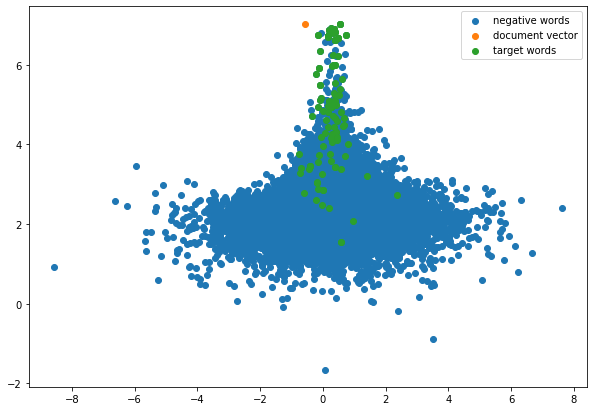

In [89]:
plt.figure(figsize=(10,7))
plt.scatter(test_word_emb[:,0], test_word_emb[:,1], label = "negative words")
plt.scatter([test_docvector[0]], [test_docvector[1]], label = "document vector")
plt.scatter(test_word_emb[target_ids,0], test_word_emb[target_ids,1], label = "target words")
plt.legend()
plt.show()